# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.plsr import MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
ABC_mc = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)

header = ABC_mc.columns
treatments = ABC_mc.columns[2:12]

data = ABC_mc.iloc[:,2:12].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

In [3]:
ABC_mc

,peptide-phosphosite,Master Protein Descriptions,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428,position
1,---MRyVASYL,60S acidic ribosomal protein P2,-0.041348,0.330638,0.079619,-0.287413,-0.230024,-0.550611,-0.398655,-0.141238,-0.088036,1.327068,Y3-p
2,---MtyAYLFK,Ras-related protein Rab-2B,0.633928,0.259916,-0.055945,-0.434915,0.208498,0.418103,0.471005,-0.675985,-0.459938,-0.364667,Y3-p
3,-MAKAyDHLFK,Ras-related protein Rab-13,0.541208,0.090077,-0.229873,-1.142080,0.287358,-0.069477,1.225244,-0.160944,-0.093620,-0.447893,Y5-p
5,-MARDyDHLFK,Ras-related protein Rab-35,0.356559,-0.176429,0.267839,-0.796749,0.275687,-0.194960,0.501464,-0.143006,0.196517,-0.286921,Y5-p
7,AAAIAyGLDRT,Heat shock 70 kDa protein 1A,0.431886,0.894781,0.373969,-0.304444,-1.203818,-0.086804,-0.276191,-0.184870,-0.155607,0.511098,Y183-p
8,AAASNyV----,Claudin-4,1.621805,1.041805,0.585895,-0.580377,-0.227355,-0.556887,-0.448397,-0.878971,0.172464,-0.729983,Y208-p
9,AAEPEyPKGIR,"Adenylate kinase 2, mitochondrial",-0.017244,0.100164,-0.087186,-1.367959,0.123011,-0.018631,-0.568576,0.760426,0.780999,0.294996,Y12-p
10,AAGYPtYRLGY,Kin of IRRE-like protein 1,1.253109,-0.216971,0.112321,-0.218133,-1.194428,-0.304462,-0.091888,-0.084560,0.294822,0.450191,T703-p
11,AANPAyGRYNP,DNA replication licensing factor MCM7,0.737244,0.324275,0.413028,0.211337,-0.486523,-0.393193,-0.142017,-0.033196,-0.131481,-0.499472,Y492-p
15,AAYDIsEDEED,Choline-phosphate cytidylyltransferase A,-0.262960,-0.046467,-0.246482,0.057388,-0.142335,-0.301030,-0.411807,-0.318526,1.931780,-0.259560,S362-p


### Phenotypes

#### Cell Viability:

% Confluency:

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]

Optionally take the fold-change to t=0:

In [5]:
# Y_cv.iloc[:, 1:] = Y_cv.iloc[:, 1:].div(Y_cv.iloc[0, 1:], axis = 1)

Define time-point of interest:

In [6]:
Y_cv = Y_cv[Y_cv["Elapsed"] == 87].iloc[0, 1:11]

## 1. Cross-validation

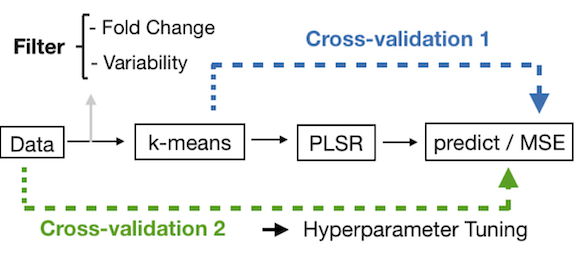

In [7]:
from IPython.display import Image
Image(filename='Model_pipeline.jpg')

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [8]:
ncl = 4

In [9]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

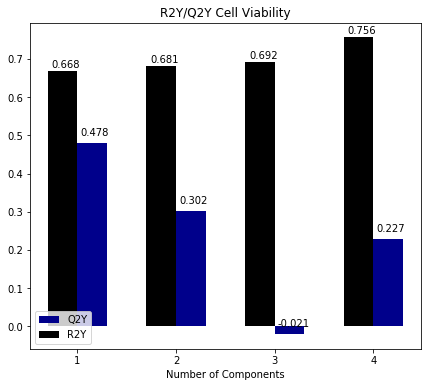

In [10]:
maxComp = ncl
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp+1)
R2Y = R2Y_across_components(centers, Y_cv, maxComp+1)
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=3)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [11]:
# CVresults_max, CVresults_min, best_params = kmeansPLSR_tuning(data, Y_cv)
# CVresults_min.nlargest(20, "mean_test_scores")

,#Clusters,#Components,mean_test_scores,mean_train_scores
2,3,1,-303.590791,-198.542229
5,4,1,-313.199872,-203.427826
54,11,1,-315.483354,-204.746172
14,6,1,-327.401230,-197.765920
20,7,1,-330.110083,-203.244759
90,14,1,-330.796916,-192.378120
104,15,1,-331.928915,-194.334752
9,5,1,-336.059347,-201.667885
35,9,1,-345.011727,-203.373471
44,10,1,-347.992956,-196.590049


## 2. Model Predicted vs Actual for best Hyperparameter Set

In [12]:
ncl, ncomp = 4, 4

### 2.1 With CV Strategy 1:

Pearson's R:  0.5645408750609303 
 p-value:  0.08909692236602618


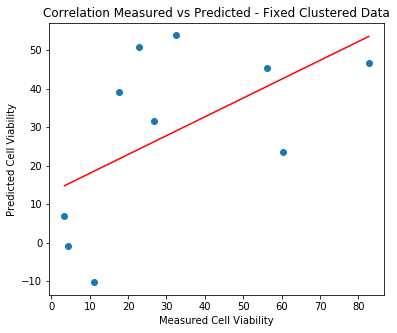

In [13]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(centers, Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

### 2.2 With CV Strategy 2:

In [19]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)

In [20]:
X_scores, Y_scores = kmeans_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = kmeans_plsr.named_steps.plsr.x_loadings_[:, 0], kmeans_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = kmeans_plsr.named_steps.plsr.y_loadings_[:, 0], kmeans_plsr.named_steps.plsr.y_loadings_[:, 1]

Pearson's R:  0.39323855650315964 
 p-value:  0.2609230415787997


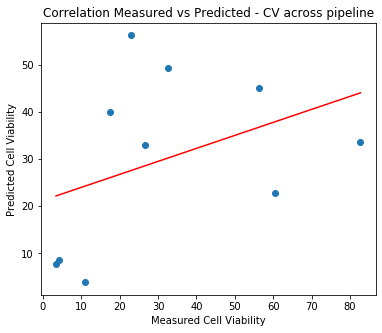

In [21]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(data, Y_cv, kmeans_plsr, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

## 3. PLSR scores and loadings 

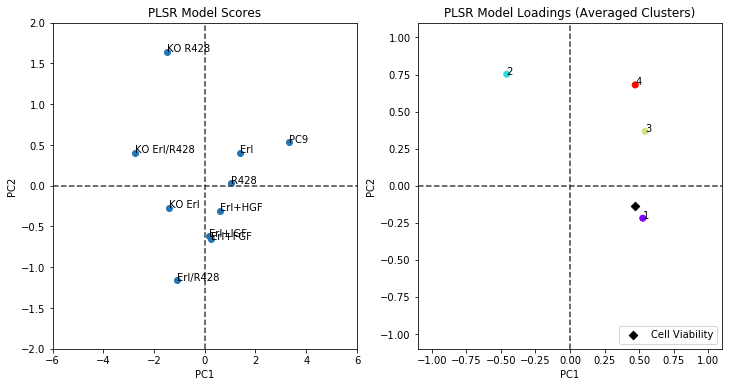

In [17]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-6, 6])
axs[0].set_ylim([-2, 2])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-1.1, 1.1])
axs[1].set_ylim([-1.1, 1.1]);

In [18]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Cluster_2,seqs_Cluster_2,Cluster_3,seqs_Cluster_3,Cluster_4,seqs_Cluster_4
0,Ras-related protein Rab-2B,---MtyAYLFK,60S acidic ribosomal protein P2,---MRyVASYL,Claudin-4,AAASNyV----,Ras-related protein Rab-13,-MAKAyDHLFK
1,Kinesin light chain 2,AEEVEyYYRRA,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR,Coactosin-like protein,ACRAAyNLVRD,Ras-related protein Rab-35,-MARDyDHLFK
2,Receptor tyrosine-protein kinase erbB-2,AENPEyLGLDV,Choline-phosphate cytidylyltransferase A,AAYDIsEDEED,Nucleophosmin,AKFINyVKNCF,Heat shock 70 kDa protein 1A,AAAIAyGLDRT
3,ATPase WRNIP1,AGEEHyNCISA,Pyruvate kinase PKM,AEAAIyHLQLF,Receptor tyrosine-protein kinase erbB-3,APHVHyARLKT,Kin of IRRE-like protein 1,AAGYPtYRLGY
4,Hepatocyte growth factor-regulated tyrosine ki...,ASSLYsSPVNS,Envoplakin,AEDAVyELQSK,Tubulin-folding cofactor B,ARLGEyEDVSR,DNA replication licensing factor MCM7,AANPAyGRYNP
5,Catenin beta-1,AVRLHyGLPVV,ADP/ATP translocase 2,ANVIRyFPTQA,Perilipin-3,ASASEyAHRGL,Mitogen-activated protein kinase 13,ADAEMtGYVVT
6,Lethal(2) giant larvae protein homolog 1,CFDPYsDDPRL,Ras and Rab interactor 1,AQDPLyDVPNA,Src substrate cortactin,ASQKDySSGFG,Protein-glutamine gamma-glutamyltransferase 2,AERDLyLENPE
7,Annexin A8,DAETLyKAMKG,Receptor tyrosine-protein kinase erbB-3,ASEQGyEEMRA,GRB2-associated-binding protein 1,CSIPRtASDTD,Transgelin-2,AGMTGyGMPRQ
8,ARF GTPase-activating protein GIT1,DDQHDyDSVAS,Cysteine and glycine-rich protein 1,CQKtVyFAEEV,Putative annexin A2-like protein,DAQDLyDAGVK,Protein tweety homolog 3,AHDSLyRVHMP
9,Actin filament-associated protein 1-like 2,DEEYIyMNKVT,FACT complex subunit SSRP1,DEYADsDEDQH,Protein 4.1,DGENIyIRHSN,Aldo-keto reductase family 1 member B1,AIDVGyRHIDC


#### Cluster Averages across Conditions